# Analýza dát z datasetu text2bank (zozbierané dáta z Profinitu)

- v tejto analýze sa zaoberáme hlavne vyťažovaním informácií o 
  - štruktúre datasetu text2bank
  - sémantickej granularite viet - intentov
  - podobností intentov medzi sebou
  - podobností intentov s názvami príslušnej triedy

In [1]:
from laserembeddings import Laser
import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, top_k_accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans

import umap

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

In [3]:
laser = Laser()

In [4]:
from sentence_transformers import SentenceTransformer

fernet = SentenceTransformer("fav-kky/FERNET-C5")

Some weights of the model checkpoint at /home/sfabo/.cache/torch/sentence_transformers/fav-kky_FERNET-C5 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
import fasttext
ft = fasttext.load_model('cc.cs.300.bin')

In [3]:
with open('intent_detector/nb_query_eval/resources/stopwords.txt') as file:
    lines = file.readlines()
    stopwords = [line.rstrip() for line in lines]

from intent_detector import nb_query_eval
tokenizer = nb_query_eval.Tokenizer(stopwords)

def ft_sent(texts):
    clean = texts
    # tkss = [tokenizer.fit(x) for x in texts]
    # clean = [' '.join([p[0] for p in tks if p[1] != 'NKW']) for tks in tkss]
    return [ft.get_sentence_vector(c) for c in clean]

Načítajme dáta

- text2bank data - 13 tried, cca. 500 intentov

In [4]:
df = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort.csv').dropna()
df.columns = ['text_cz', 'kategorie']

## Kosínové podobnosti K(intent, intent) v ramci triedy "limity" z t2b

- vybratá trieda: "limity"
- z tejto triedy vyberieme 5 viet pre lepšiu vizualizáciu (matica bola skonštruovaná najprv na všetkých vetách z triedy limity a potom boli vybrané najzaujímavejšie kúsky)

### Čo sa snažíme ukázať?

- či sa vety (intenty) v rámci svojej triedy na seba podobajú a ako veľmi
- použime FASTTEXT pre tvorbu embeddingov a kosínovú podobnosť

### Prečo to chceme vedieť?

- v akej kvalite sme dáta zozbierali
- či sa v tejto triede nájdu aspoň dve-tri vety s rovnakou sémantikou
- poskytnúť malú ukážku akú má táto náhodne zvolená trieda sémantickú granularitu


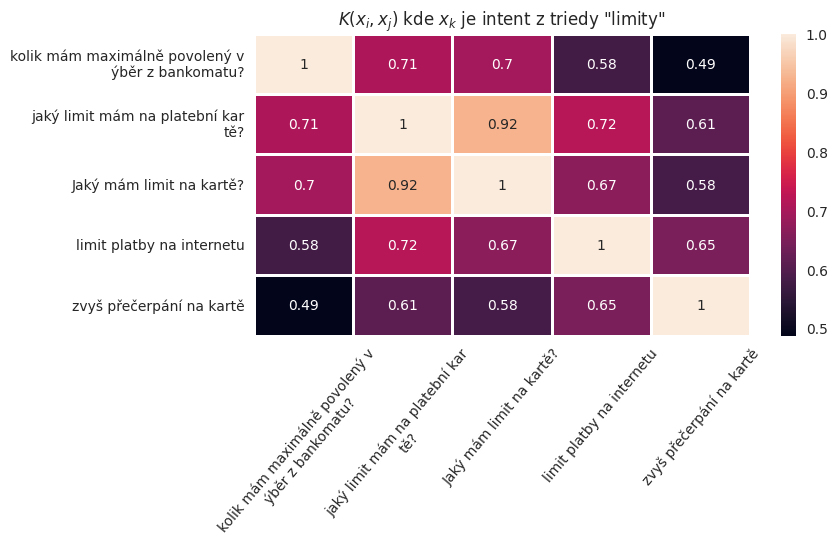

In [40]:
sample_class = df.iloc[150, 1]
sample_class = 'limity'
texts = df[df['kategorie'] == sample_class]['text_cz'][[158, 157, 150, 159, 167]]

# texts_embeddings_laser = laser.embed_sentences(texts, lang='cs')
texts_embeddings_laser = ft_sent(texts)
simils_l = [cosine_similarity([texts_embeddings_laser[i]], texts_embeddings_laser[:]).flatten() for i in range(len(texts_embeddings_laser))]
data = np.array(simils_l)

xlabels = texts
xlabels_new = [re.sub("(.{30})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]

plt.figure(dpi=100, figsize=(8,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=xlabels_new, yticklabels=xlabels_new)
plt.title(f'$K(x_i, x_j)$ kde $x_k$ je intent z triedy "{sample_class}"')
plt.xticks(rotation = 50)
plt.show()

### Pozorovanie

**vyššie vidíme kosínové podobnosti: K(veta_i, veta_j) z tej istej triedy**


- Očakávanie pri týchto vizualizaciách boli vysoké čísla na celej matici podobnosti, to sa stalo len v niektorých pripadoch.
- "jaký mám limit na kartě" a "jaký mám limit na _platební_ kartě" s hodnotou 0,91: jedno slovo pridané do úplne rovnakej vety nám dá vysokú mieru podobnosti, podľa očakávaní.
- Oproti tomu vety "kolik mám maximálne povolený výběr z bankomatu" a "limit platby na internetu" majú nízku mieru podobnosti s hodnotou 0,45. Jedná sa o úplne odlišné zámery, avšak oba patria v tomto datasete do tej istej triedy.
- napríklad "limit platby na internetu" je nepodobná so skoro všetkými vybranými vetami. Táto veta má však zvláštnu vetnú štruktúru a slovosled, je možné, že je to spôsobené práve týmto.


### Záver

- granularita triedy "limity" je príliš nízka, zámery z tejto triedy by sa hodili rozhodiť do ďalších podtried, alebo triedu úplne vyhodiť

## Kosínová podobnosť K(intent z triedy "limity", názvy tried)

### Čo chceme ukázať?

- zoberme vyššie spomínaných 5 zámerov z triedy limity a pozrime sa na kosínovú podobnosť embeddingov týchto zámerov a názvov všetkých tried z datasetu

### Prečo to chceme vedieť?

- hypoteticky by sme mohli vytvoriť klasifikačný model len na základe podobnosti intentov a názvov tried. Poďme teda overiť, ako by takáto "klasifikácia" približne dopadla.


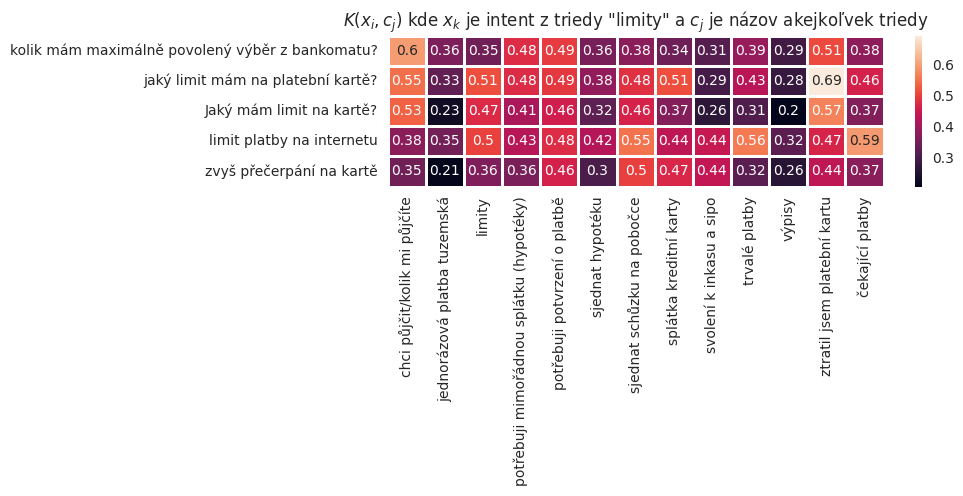

In [41]:
# classes_emb = laser.embed_sentences(df['kategorie'].sort_values().unique(), lang='cs')
classes_emb = ft_sent(df['kategorie'].sort_values().unique())
data = cosine_similarity(texts_embeddings_laser, classes_emb)

plt.figure(dpi=100, figsize=(8,2))
heat_map = sns.heatmap(data, linewidth = 1 , annot = True, yticklabels=texts, xticklabels=df['kategorie'].sort_values().unique())
plt.title(f'$K(x_i, c_j)$ kde $x_k$ je intent z triedy "{sample_class}" a $c_j$ je názov akejkoľvek triedy')
plt.show()

### Pozorovanie

- očakávanie pre overenie správnosti hypotézy: stĺpček bielej farby (vysoké hodnoty podobnosti) pri názve triedy "limity". 
- vidíme: v podstate šum.  Ak by sme sa pokúsili klasifikovať týchto 5 vzorkov pomocou modelu "veta podobná s názvom triedy", dosiahli by sme nízku úspešnosť.

### Záver

Názov aj význam tejto triedy má podľa všetkého tak široké zameranie (jedno slovo "limity"), že FASTTEXT na to reaguje veľmi rozdielnymi embeddingami.


**Možné vylepšenie triedy "limity":** vytvoriť nové podtriedy (zmena/zobrazenie limitu {platba kartou, výber z bankomatu, ...}), ale to by celé riešenie problému klasifikácie textu pravdepodobne ešte viac skomplikovalo, pretože by pribudlo veľmi veľa nových tried a bolo by nutné vytvoriť alebo získať ďalšie dáta.

**Zvoľme teda inú triedu a preveďme podobné vizualizácie:**

## Kosínová podobnosť FASTTEXT embeddingov K(intent, intent) kde intenty sú z triedy "chci půjčit/kolik mi půjčíte"


### Čo chceme urobiť?

- zoberme náhodnú vzorku 10 intentov z tejto triedy, vytvorme z nich embeddingy a s rovnakým postupom ako pri predošlej triede vytvorme maticu podobností

### Prečo to chceme urobiť?

- uvidíme či vety z inej triedy by nemali lepšie výsledky na potvrdenie rovnakých dohadov ako pri triede limity.

In [42]:
sample_class = 'chci půjčit/kolik mi půjčíte'
texts = df[df['kategorie'] == sample_class]['text_cz']
# texts_embeddings_laser = laser.embed_sentences(texts, lang='cs')

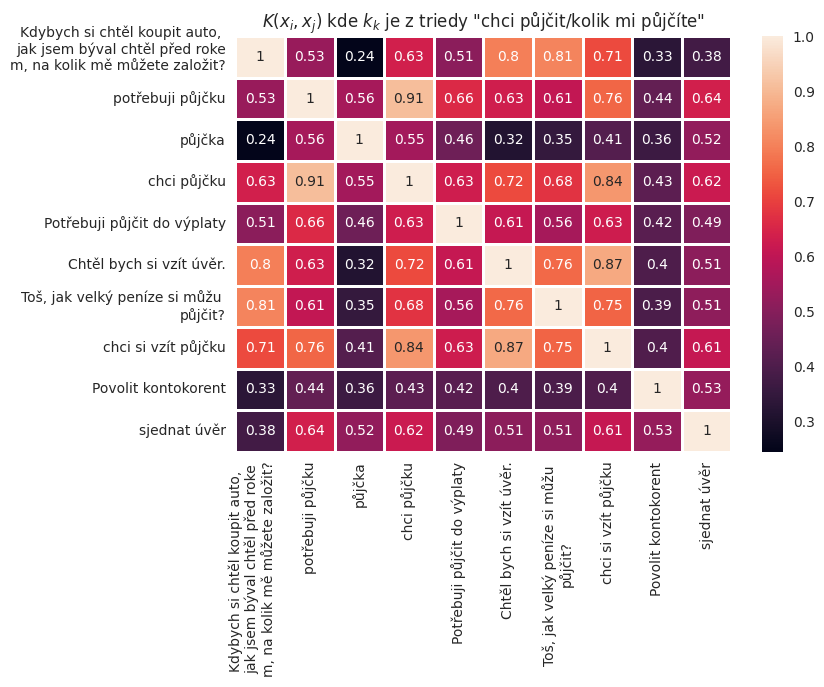

In [43]:
samples20 = texts.sample(10, random_state=21)
texts_embeddings_laser = ft_sent(samples20)

simils = [cosine_similarity([texts_embeddings_laser[i]], texts_embeddings_laser[:]).flatten() for i in range(len(texts_embeddings_laser))]
data = np.array(simils)


xlabels = samples20
xlabels_new = [re.sub("(.{30})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]

plt.figure(dpi=100)
heat_map = sns.heatmap(data, linewidth = 1 , annot = True, xticklabels=xlabels_new, yticklabels=xlabels_new)
plt.title(f'$K(x_i, x_j)$ kde $k_k$ je z triedy "{sample_class}"')
plt.show()

### Pozorovanie

- na matici je omnoho viac vyšších hodnôt podobnosti ako pri rovnakej matici vytvorenej na vetách z triedy limity.
- jediné dve vyčnievajúce vety sú tie najdlhšie
- Dlhé vety sú podľa všetkého problémom pre embeddéry všeobecne (TOTO BY SI MAL OVERIŤ niekde v literatúre, Samuel). 
- Ukazuje sa to na vete "kdybych si chtel koupit auto..." (ale aj pri vete z predošlej triedy "kolik mám maximálne výber z...").
  - hlavným obsahom tejto dlhej vety je, samozrejme, "na kolik mě můžete založit". 
  - Ak sa pozrieme na kos. podobnosť K("kdybych si ... muzete zalozit", "na kolik mě můžete založit"), vyjde nám hodnota 0,59, čo je stále málo napriek podobnej výpovednej hodnote oboch viet.

### Záver

- až na výnimky je tento výber 10tich viet z triedy "chci půjčit/kolik mi půjčíte" navzájom sémanticky vcelku podobný. 
- Môžeme sa teda domnievať, že táto trieda má vyššiu sémantickú granularitu v zmysle podobnosti embeddingov viet.

## Kosínová podobnosť K(intent, názvy všetkých tried) triedy "chci si pujčit"

- vzorka rovnakých 10 intentov ako v predchádzajúcom skúmaní

### Čo chceme ukázať?

- zoberme vyššie použitých 10 zámerov z triedy "chci si pujčit" a pozrime sa na kosínovú podobnosť embeddingov týchto zámerov a názvov všetkých tried z datasetu

### Prečo to chceme vedieť?

- hypoteticky by sme mohli vytvoriť klasifikačný model len na základe podobnosti intentov a názvov tried. 
- Poďme teda overiť, ako by takáto "klasifikácia" približne dopadla.


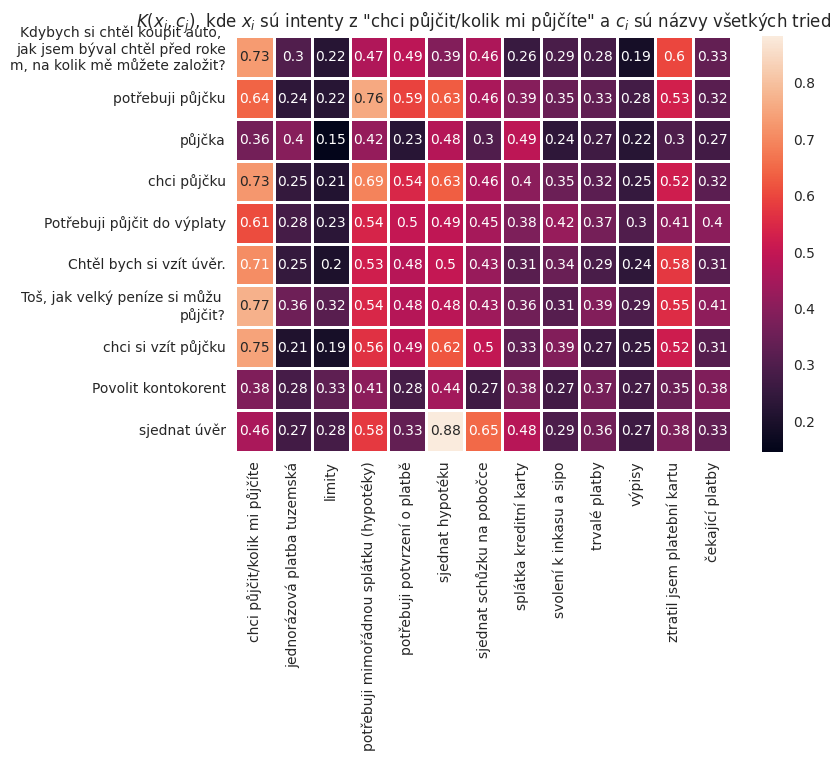

In [44]:
# texts_embeddings_fernet = fernet.encode(list(samples20)).tolist()
texts_embeddings_laser = laser.embed_sentences(list(samples20), lang='cs')
texts_embeddings_laser = ft_sent(list(samples20))

class_names = df['kategorie'].sort_values().unique()
# classes_emb = laser.embed_sentences(list(class_names), lang='cs')
classes_emb = ft_sent(list(class_names))
data = cosine_similarity(texts_embeddings_laser, classes_emb)

xlabels = samples20
xlabels_new = [re.sub("(.{30})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]

plt.figure(dpi=100)
heat_map = sns.heatmap(data, linewidth = 1 , annot = True, yticklabels=xlabels_new, xticklabels=class_names)
plt.title(f'$K(x_i, c_j)$, kde $x_i$ sú intenty z "{sample_class}" a $c_i$ sú názvy všetkých tried')
plt.show()

In [45]:
simil_classes = np.mean(data, axis=0)
print("Priemerna kosínová podobnosť FASTTEXT embd.: K(intent, vsetky názvy tried):\n", np.around(simil_classes, 2))
print('Najpodobnejšia trieda priemernej cos simil zoznamu vyššie:', class_names[np.argmax(simil_classes)])

Priemerna kosínová podobnosť FASTTEXT embd.: K(intent, vsetky názvy tried):
 [0.61 0.28 0.24 0.55 0.44 0.56 0.44 0.38 0.33 0.32 0.26 0.47 0.34]
Najpodobnejšia trieda priemernej cos simil zoznamu vyššie: chci půjčit/kolik mi půjčíte


### Pozorovanie

- zdá sa, že názov tejto triedy ("chci půjčit/kolik mi půjčíte") rozumne zachycuje jej sémantický význam
  - to si môžeme všimnúť na priemernej cos_simil 10 vzorkov z triedy "chci si pujcit" pre všetky triedy
- Ak by sme použili podobnosť ako klasifikátor, v tomto prípade by sme dostali na prvé miesto správnu príslušnú triedu pre väčšinu intentov z triedy.
  - je dôležité všimnúť, že priemer hodnôt kosínových podobností má veľmi podobné hodnoty s ďalšími triedami.
- všimnime si vysokej hodnoty podobnosti 0,79 pri intente "potřebuji půjčit do výplaty" a názve triedy "potřebuji potvrzení o platbě". 
  - zdá sa, že jediné podobné slovo vo vetách vie zamávať s hodnotami a v tomto prípade by klasifikátor urobil chybu (len preto, že půjčit a půjčíte sú vyskloňované a potřebuji majú rovnaký slovný tvar)
- zdá sa, že naozaj záleží na dĺžke vety, všimnime si vysoké hodnoty pri intente "půjčka", s názvami tried "výpisy" a "limity". Tieto slová spolu zjavne nesúvisia.

### Záver

- vetné embeddingy nie príliš vypovedajú o príslušnosti intentov z jednej triedy k názvu triedy
- pre týchto 10 vzorkov sa hypotetická klasifikácia javí ako prijateľná, avšak s neodpustiteľnými chybami, popísanými vyššie.
- FASTTEXT embeddingy nie sú príliš použiteľné pre dlhé a jednoslovné vety.

## UMAP z FASTTEXT embeddingov a KMeans klastering všetkých intentov, každá trieda separátne

### Čo chceme ukázať?

- pozrime sa na UMAP embeddingy z FASTTEXT embeddingov, pre lepšiu vizualizáciu
- pomocou [klastrovacieho algoritmu KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) nájdime pre každú triedu tri klastre a farebne odlíšme každý kluster v 2D UMAP priestore.
  - vypíšme cca tretinu viet z každého nájdeného klastru

### Hypotéza na preverenie

- Existujú triedy, kde vetné embeddingy intentov k príslušnej triede sú navzájom veľmi odlišné?
  - ak existujú, treba ich nájsť a vytvoriť prípadné podtriedy
  - ak neexistujú, triedu do podtried nerozbíjame

poznámka: UMAP parametre v poradí: `n_neighbors, min_dist, metric`. [Popísané tu](https://umap-learn.readthedocs.io/en/latest/parameters.html) boli zvolené štýlom pokus omyl

UMAP params: (5, 0.001, 'cosine')


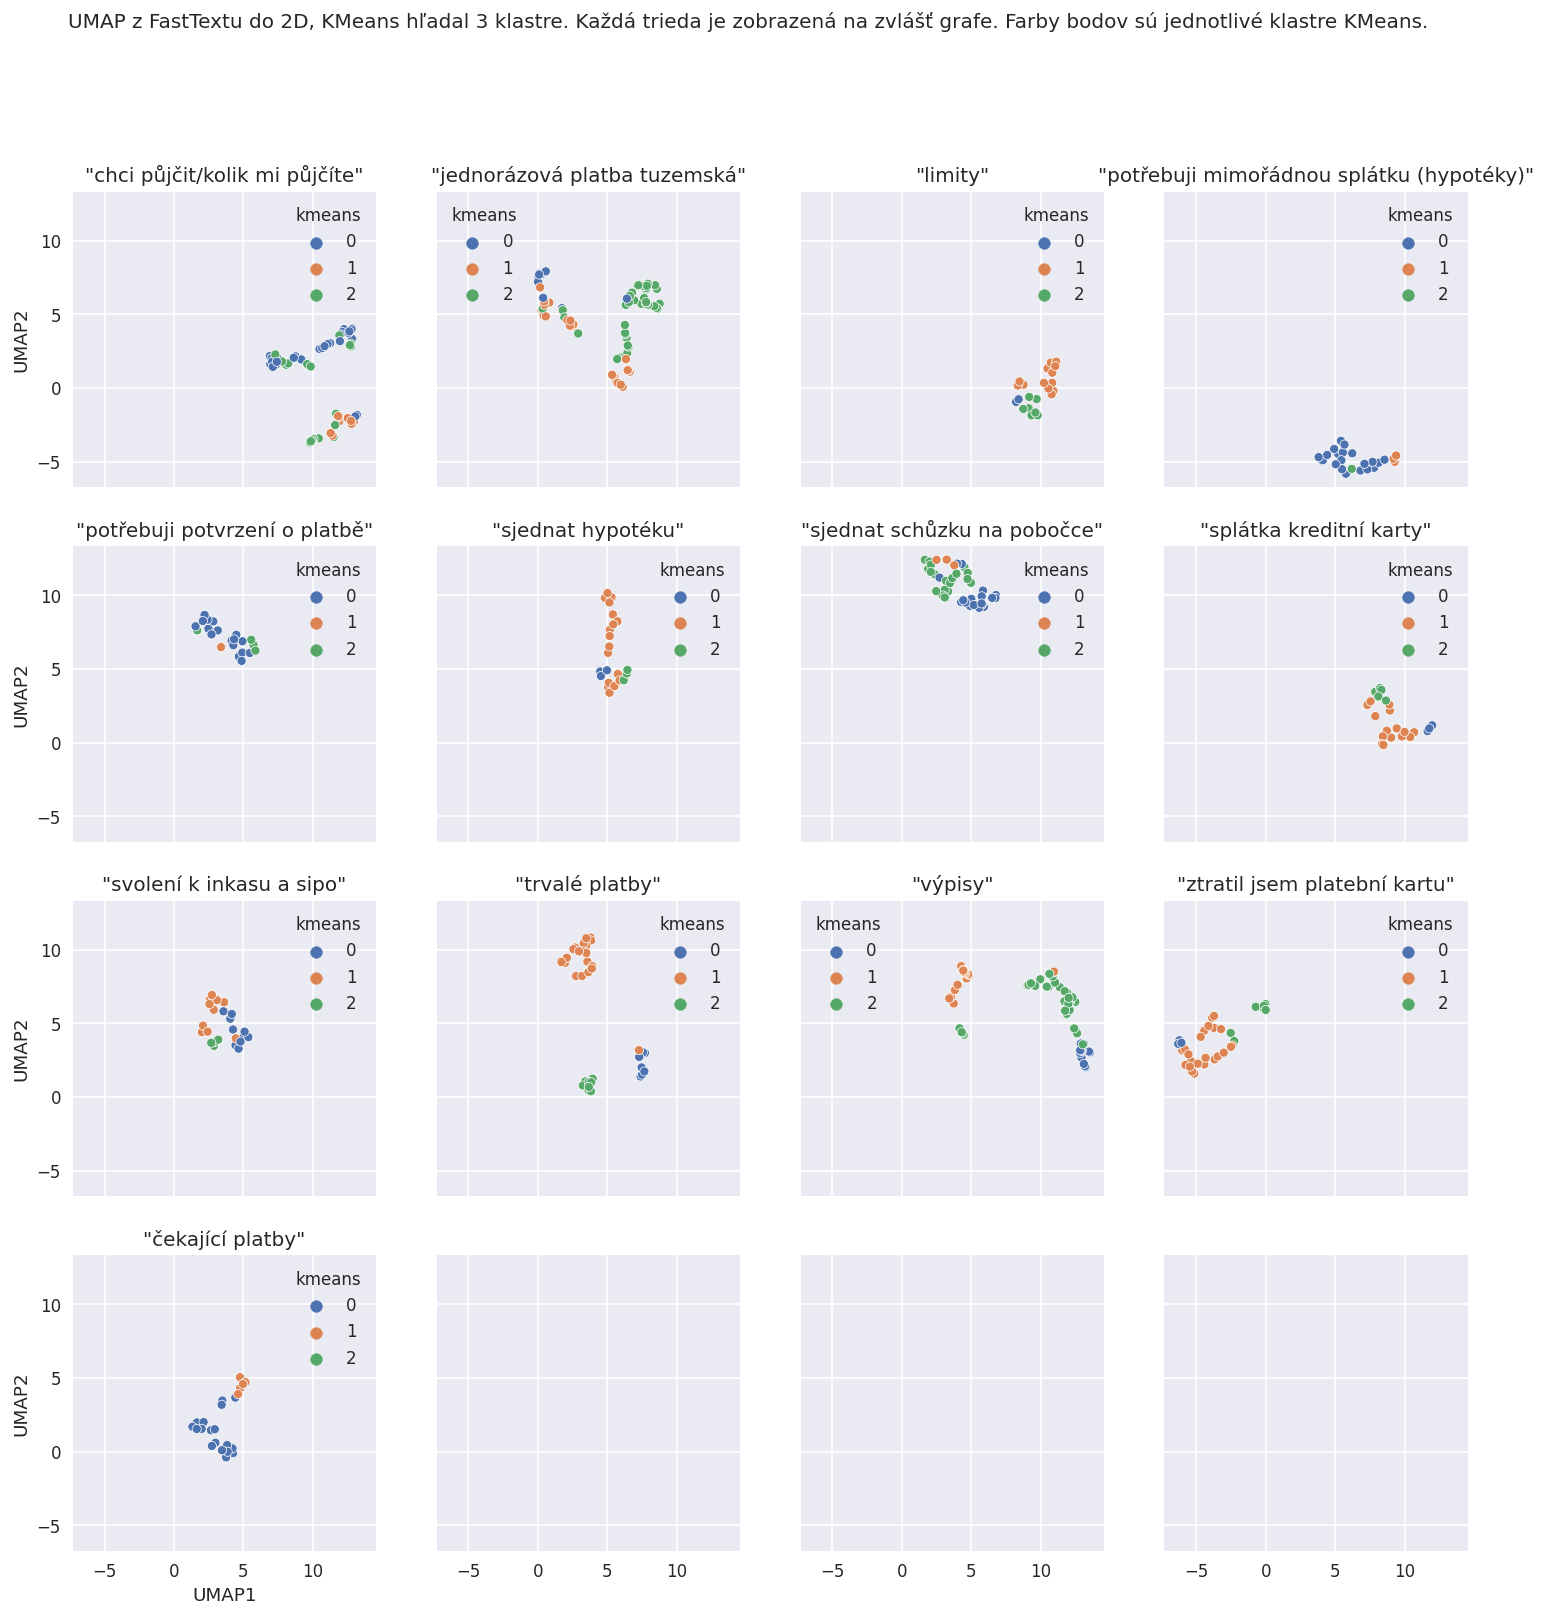

In [8]:
nei, md, metr = 5, .001, 'cosine'
n_clusters = 3

print('UMAP params:', (nei, md, metr))

t2b_enhanced = pd.DataFrame()

r_ax, c_ax = 4, 4

fig, axes = plt.subplots(nrows=r_ax, ncols=c_ax, sharex=True, sharey=True, dpi=120, figsize=(15,15))

labels = df['kategorie'].unique()

for i in range(len(labels)):
    
    l = labels[i]
    t2b = df.copy()
    data = t2b[t2b['kategorie'] == l].reset_index(drop=True)

    # embd_laser = laser.embed_sentences(data['text_cz'], lang='cs')
    embd_laser = list(ft_sent(data['text_cz']))
    u = umap.UMAP(metric=metr, random_state=999, n_neighbors=nei, min_dist=md)
    embd_umap = u.fit_transform(embd_laser)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embd_laser)


    embedding = pd.DataFrame(embd_umap, columns = ['UMAP1','UMAP2'])
    embedding = pd.concat([data, embedding], axis='columns').reset_index(drop=True)
    embedding['kmeans'] = kmeans.labels_

    t2b_enhanced = pd.concat([t2b_enhanced, embedding], axis='rows').reset_index(drop=True)

    row, col = int(i / c_ax), i % c_ax

    ax = axes[row, col]

    sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kmeans', palette='deep', ax=ax, s=30)
    ax.title.set_text(f'"{l}"')

fig.suptitle(f'UMAP z FastTextu do 2D, KMeans hľadal {n_clusters} klastre. Každá trieda je zobrazená na zvlášť grafe. Farby bodov sú jednotlivé klastre KMeans.')
plt.show()

In [47]:
for c in t2b_enhanced['kategorie'].unique()[:]:
    print(c.upper(), end='\n')
    d = t2b_enhanced[t2b_enhanced['kategorie'] == c]
    for i in range(3):

        print(d[d['kmeans'] == i]['text_cz'].sample(frac=0.3, random_state=42).tolist())
    print()

CHCI PŮJČIT/KOLIK MI PŮJČÍTE
['kolik si mam půjčit, abych byl zadlužený na celý život?', 'dá se vypočítat kolik teoreticky bych dostal úvěr?', 'Jak si mohu zvýšit kontokorent?', 'Toš, jak velký peníze si můžu půjčit?']
['dej mi peníze', 'mohu dostat půjčku?', 'půjčit si', 'půjčení peněz', 'chci si koupit nove auto', 'potřebuji půjčku', 'mám dotaz na sjednání půjčky', 'chci si vzít půjčku', 'úvěr', 'chci si půjčit 1M kč']
['dá se zde půjčit 5000 korun?', 'Půjčka 1200k na auto.', 'Chtěl bych půjčit 50000 kč', 'Půjčka 1200k Kč na auto']

JEDNORÁZOVÁ PLATBA TUZEMSKÁ
['zaplatit fakturu', 'zaplatit splátku', 'Zaplatit nájem', 'domácí platba', 'spořit', 'poslat známému peníze', 'chci poslat peníze', 'převod peněz mezi bankama', 'poslat peníze', 'kolik je úroková sazba?', 'nová platba', 'chci poslat peníze maminke']
['poslat 200 korun matce na 12345678/2010', 'Chci poslat 299€ na účet 9876543210/1234', 'zadat platbu 12000 na účet 167559324/0300 se zprávou "servis Peugeot"']
['poslat 500 matce.

### Pozorovanie

- grafy vyššie ukazujú UMAP zobrazenie FASTTEXT embeddingov intentov pre každú triedu zvlášť do 2D priestoru. Farby bodov na grafoch sú podľa čísla klastru nájdeného pomocou KMeans algoritmu
- texty nižšie ukazujú náhodnú tretinu intentov z každého klastru pre každú triedu zvlášť
- Popíšme si niektoré zaujímavé triedy:
  - pri triede "chci si půjčit" vidíme, že klaster 2 združuje vety s číslovkou v texte, klaster 0 sú len otázky.
  - triedu "limity" UMAP ani KMeans nebol schopný rozdeliť do viac ako dvoch klastrov - v klastri 2 vidíme číslovky
  - trieda "trvalé platby" boli UMAPom aj KMeans rozdelené na 3 klastre, kde 0 reprezentuje dlhšie a komplikovanejšie vety, v 1 sa vyskytuje spojenie "trvalé platby" a v 2 "trvalý příkaz" 
  - trieda "svolení k inkasu a SIPO" je KMeansom naklastrované v podobnom duchu ako "chci si půjčit"
  - ostatné triedy sa alebo ťažko interpretujú alebo nie sú zaujímavé

### Záver

- FASTTEXT je očividne náchylný nielen na dĺžku vety, ale aj na čísla vo vetách. Toto by bolo vhodné predspracovať a všetky čísla nahradiť nejakým unikátnym tokenom.
- hypotéza sa, zdá sa, potvrdila len pre niektoré triedy (intent ktorý je otázkou má zjavne iný zámer ako nejaká akcia/príkaz)
  - Síce sa na UMAPe javí, že napr. trieda "jednorázová platba tuzemská" má tak 3 klastre, pri výpise vzorku viet v tejto triede je jasné, že odlíšenie je minimálne a závisí to len na čísliciach alebo dĺžke textu, pri iných sú to práve otázky, ktoré priestor rozdeľujú
- mnohé triedy (napr. limity) sú po zobrazení do UMAP 2D priestoru pokope. Intenty sú tu podľa predchádzajúceho skúmania dosť rozličné.
- Dôležité: FASTTEXT nám pri rozdeľovaní do podtried asi nepomôže. Bude to treba skontrolovať manuálne.

#### Hypotéza na preverenie

- ak nahradíme číslice tokenmi, aký by bol výsledok?
  - pomohlo by nám to vôbec?
- ak chceme budovať znalostnú bázu, môžeme ju založiť na vyčistených dátach (odstránime irelevantné a vtipné intenty a ponecháme len naozaj relevantné)?
  - fungovalo by to na princípe: "je váš zámer podobný tomuto: ...?", keďže vo vetách sú aj otázky a rôzne zámery, ktoré treba nejak vyhodnotiť

## UMAP z FASTTEXT embeddingov všetkých intentov

Redukujme dimenziu LASERu na 2 pomocou UMAP a vizualizujme všetky intenty odlíšené farbami. Ak však dáme všetky triedy do jednej projekcie, uvidíme skôr šum a sem-tam zhluk intentov rovnakej triedy. Nebolo by to vhodné na vizualizáciu, preto rozdeľme všetky triedy do 4 kúskov (v poradí ako sú v datasete)

- chceme ukázať, či sa intenty rôznych tried od seba líšia v priestore embeddingov

### Hypotéza

- ako veľmi dú intenty zašumené?

In [9]:
t2b = df.copy()
data = df.copy()

embd_laser = ft_sent(data['text_cz'])
u = umap.UMAP(metric=metr, random_state=999, n_neighbors=nei, min_dist=md)
embd_umap = u.fit_transform(embd_laser)

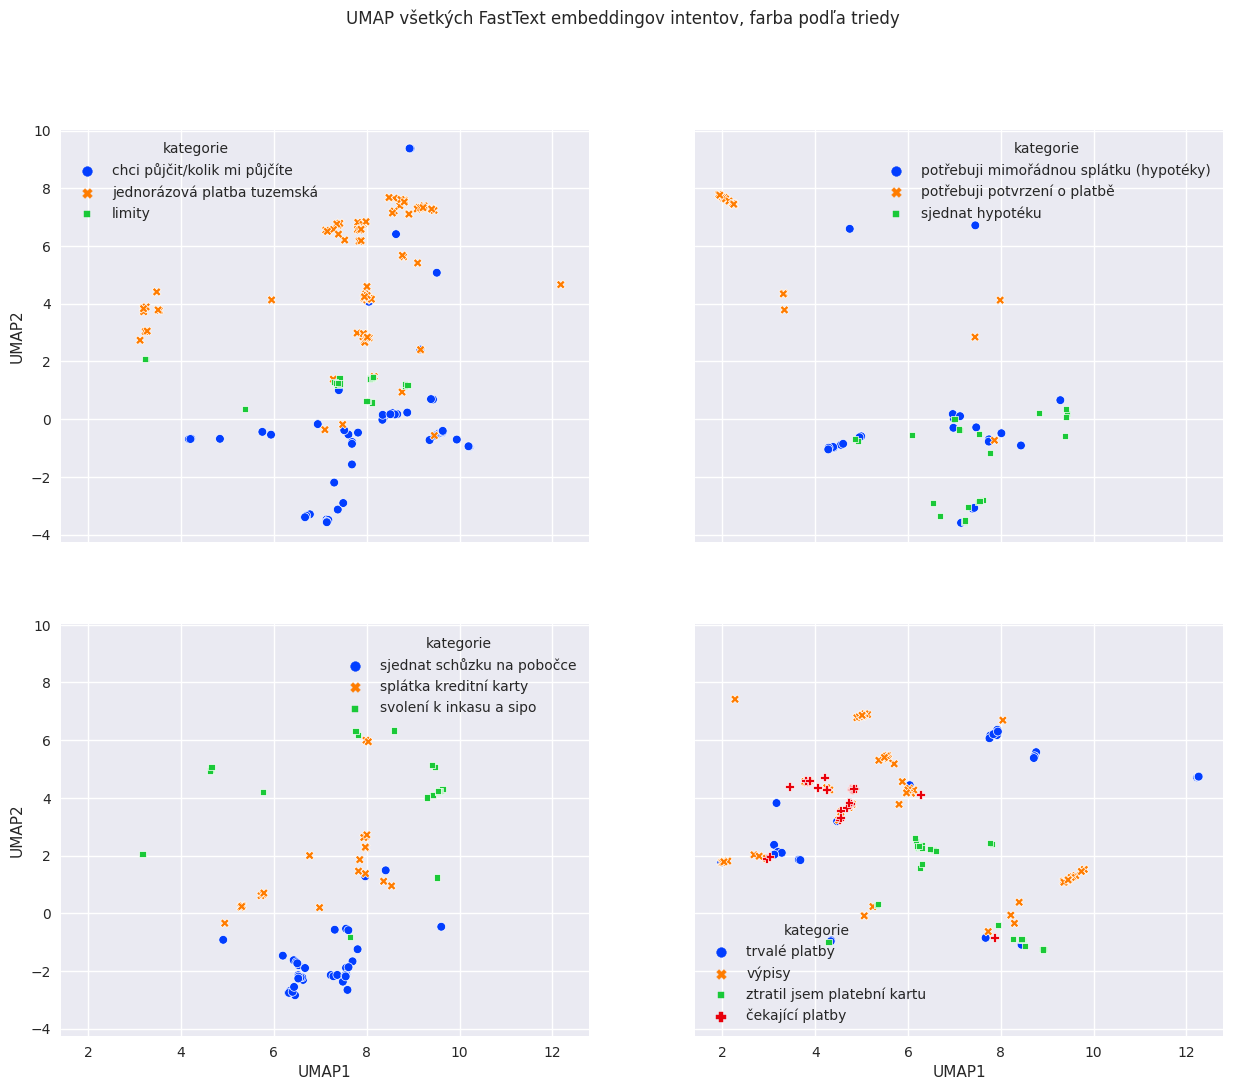

In [11]:
r_ax, c_ax = 2, 2

fig, axes = plt.subplots(nrows=r_ax, ncols=c_ax, sharex=True, sharey=True, dpi=100, figsize=(15,12))

a = 0

for i in range(0, 12, 3):

    embedding = pd.DataFrame(embd_umap, columns = ['UMAP1','UMAP2'])
    embedding = pd.concat([data, embedding], axis='columns').reset_index(drop=True)

    labels = embedding['kategorie'].unique()
    end = i+3 if i < 9 else i+4
    # print((i, end))
    embedding = embedding[embedding['kategorie'].isin(labels[i:end])]

    row, col = int(a / c_ax), a % c_ax
    # print((row,col))
    a += 1
    ax = axes[row, col]

    sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kategorie', palette='bright', style='kategorie', s=40, ax=ax)

fig.suptitle('UMAP všetkých FastText embeddingov intentov, farba podľa triedy')
plt.show()

### Pozorovanie

- okrem trojice tried vľavo dole sa javia všetky intenty veľmi zašumené
- nejaké drobné zhluky môžeme vidieť v každej sekcii, ale nejaví sa to ako dostačujúce oddelenie
  - zhluky na projekcii vpravo dole sú veľmi slabo viditeľné

### Záver

- Výsledok pozorovania je ťažko interpretovateľný
- Dáta sa javia veľmi zašumené, je potrebné predspracovanie a zvýšenie kvality intentov
  - avšak šum môže byť spôsobený nedokonalosťou UMAPu

## Kosínová podobnosť K(intent, vlastný názov triedy) pre tri embedéry

- pozrime sa na embeddingy všetkých intentov a názvov všetkých tried
- porovnajme týmto niektoré vybrané modely, ktoré embeddingy vedia vytvoriť (fasttest, FERNET, LASERr) navzájom medzi sebou
  - pomocou kosínovej podobnosti K(intent, názov príslušiacej triedy)

### Čo tým chceme ukázať

- ako vyzerá rozloženie hodnôt kosínovej podobnosti

In [29]:
cats = df['kategorie'].unique()

text_embs = fernet.encode(df['text_cz']).tolist()
class_embs = fernet.encode(df['kategorie'].unique()).tolist()

data = df.copy()

data = data.reset_index(drop=True)

cos_simil_laser = cosine_similarity(text_embs, class_embs)

print(cos_simil_laser.shape)


(490, 13)


In [35]:
cats = df['kategorie'].unique()


res = pd.DataFrame()


def ft_sent(texts):
    return [ft.get_sentence_vector(c) for c in texts]

def laser_sent(texts):
    return laser.embed_sentences(texts, lang='cs')



for emb_type, embed in {'FERNET': fernet.encode, 'FastText': ft_sent, 'FASTTEXT': laser_sent}.items():

    print(embed)

    class_embs = list(embed(cats))

    for ic in range(len(cats)):
        # idxs = data[data['kategorie'] == cats[ic]].index
        samples = df[df['kategorie'] == cats[ic]]['text_cz'].tolist()
        text_embs = list(embed(samples))

        cos_simil = cosine_similarity(text_embs, [class_embs[ic]]).flatten()
        res_corr = pd.DataFrame({"cos_simil": cos_simil, "kategorie": cats[ic], "vlastna_trieda": True, 'emb_type': emb_type})

        cos_simil = cosine_similarity(text_embs, [x for i, x in enumerate(class_embs) if i!=ic]).flatten()
        res_other = pd.DataFrame({"cos_simil": cos_simil, "kategorie": cats[ic], "vlastna_trieda": False, 'emb_type': emb_type})

        res = pd.concat([res, res_corr, res_other], axis='rows')
        # res = pd.concat([])


# g = sns.FacetGrid(res, col="emb_type", hue="corresponds")
# g.map(sns.boxplot, "cos_simil", "classes", orient='h')
# g.add_legend()

<bound method SentenceTransformer.encode of SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)>
<function ft_sent at 0x7f5b048b7af0>
<function laser_sent at 0x7f5b046b5e50>


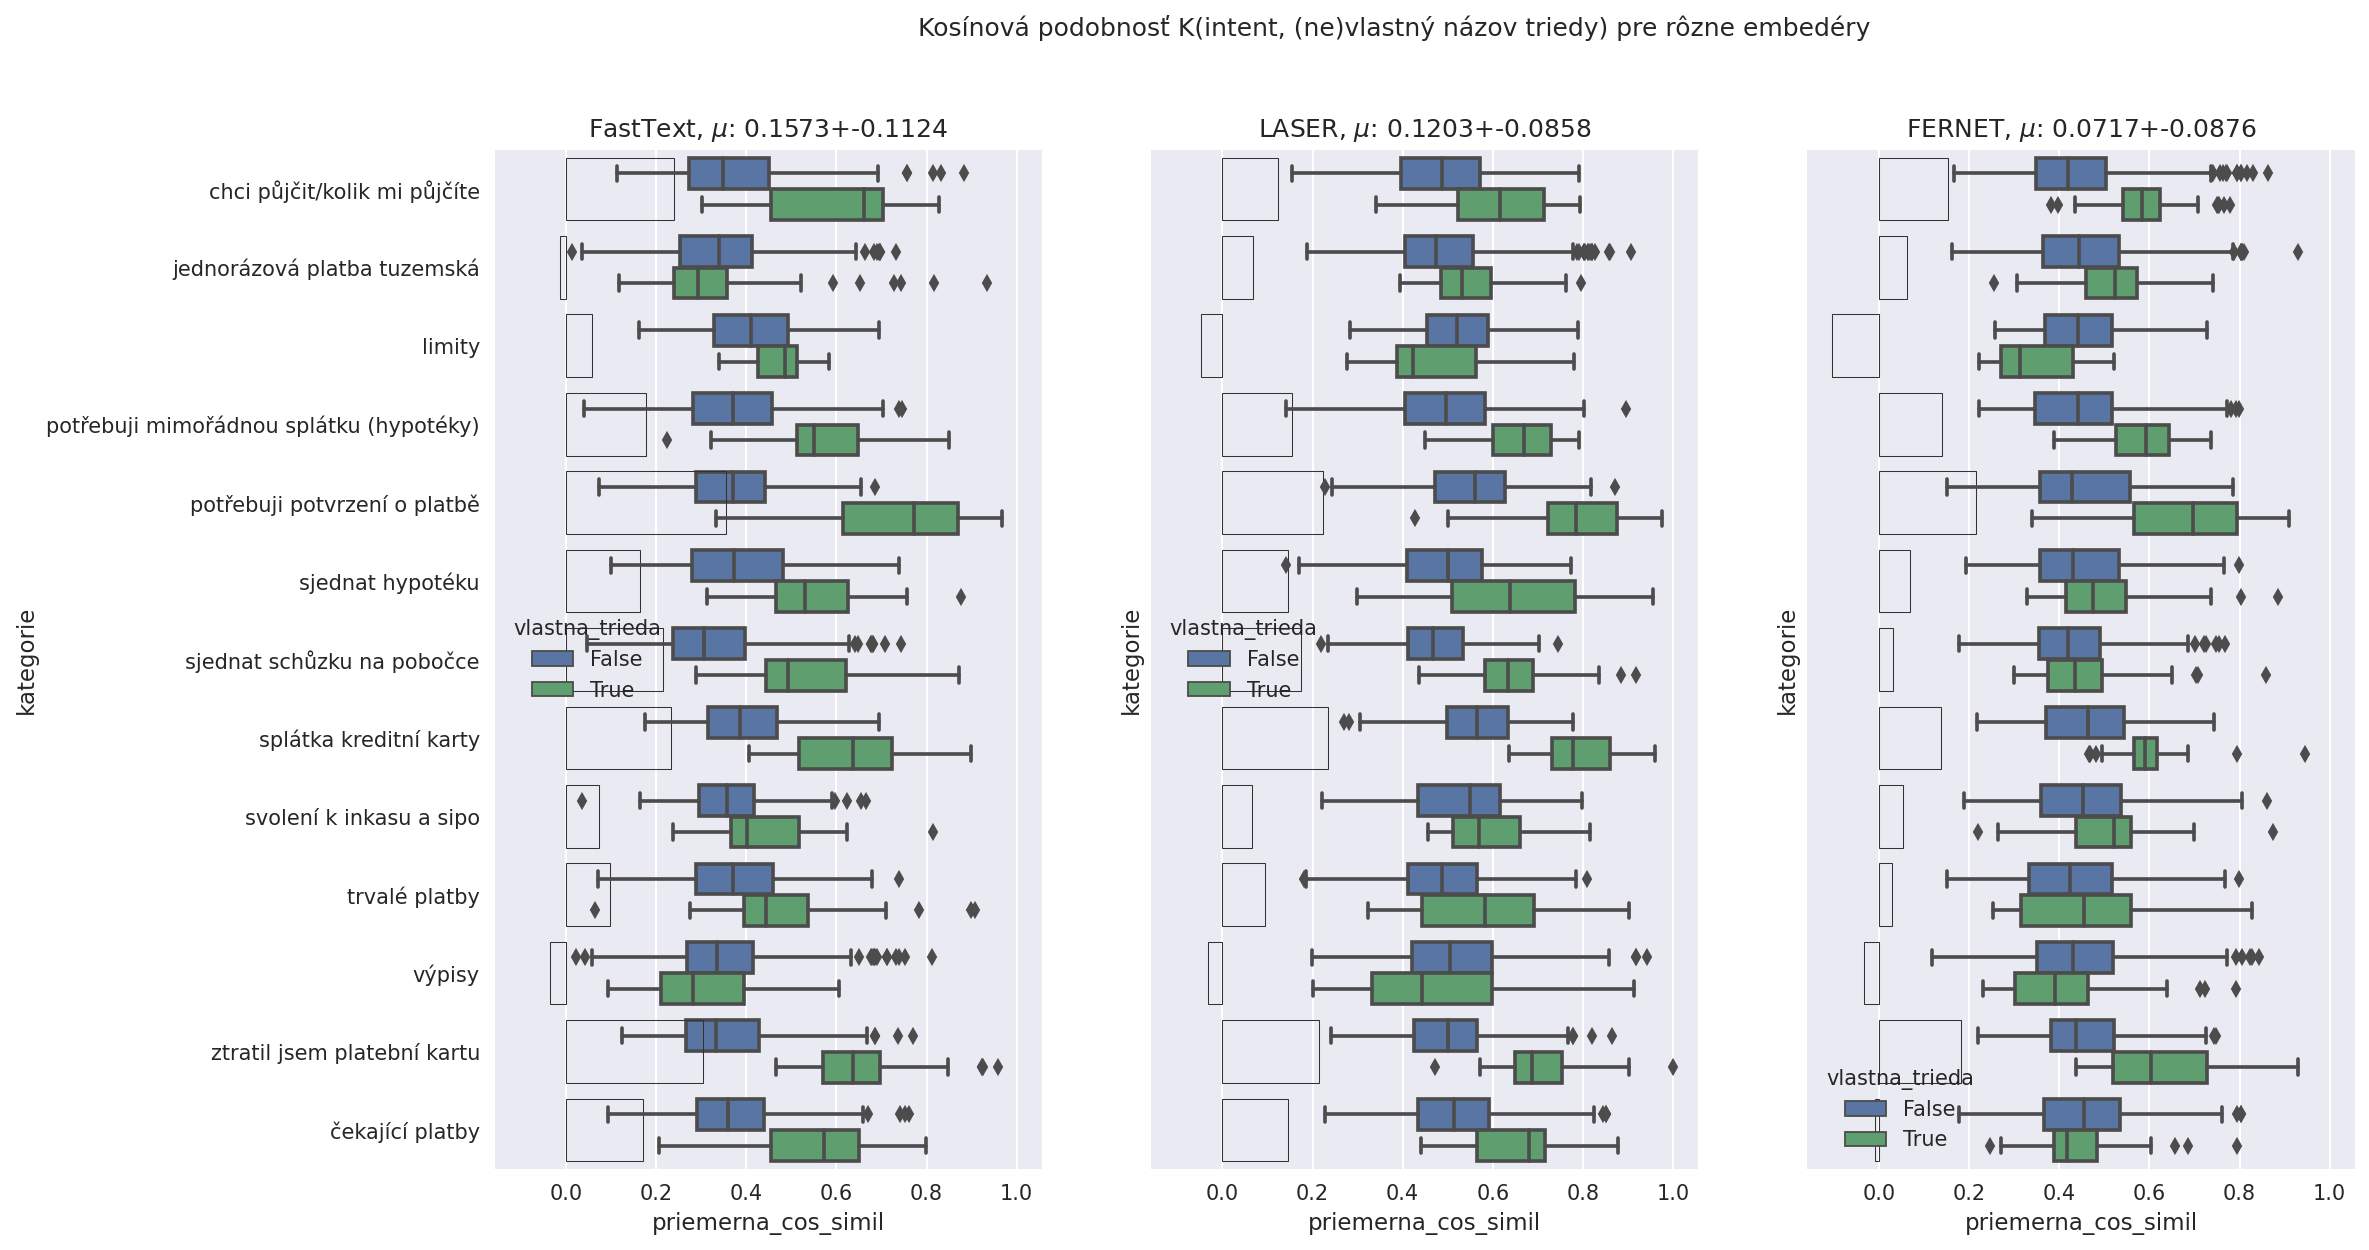

In [38]:
r_ax, c_ax = 1, 3

fig, axes = plt.subplots(nrows=r_ax, ncols=c_ax, sharex=True, sharey=True, dpi=150, figsize=(16,9))

for col, emb_type in enumerate(['FastText', 'LASER', 'FERNET']):

    r = res[res['emb_type'] == emb_type]
    grup = r.groupby(['kategorie', 'vlastna_trieda']).mean()
    
    d_median = [grup.iloc[i]['cos_simil'] - grup.iloc[i-1]['cos_simil'] for i in range(1, len(cats) * 2, 2)]

    mean_med = np.mean(d_median)
    std_med = np.std(d_median)

    deltas = pd.DataFrame({'kategorie': cats, 'priemerna_cos_simil': d_median})

    ax = axes[col]
    ax.title.set_text(f'{emb_type}, $\mu$: {mean_med:.4f}+-{std_med:.4f}')
    sns.boxplot(data=res[res['emb_type'] == emb_type], x="cos_simil", y="kategorie", hue='vlastna_trieda', orient='h', ax=ax)
    sns.barplot(data=deltas, x="priemerna_cos_simil", y="kategorie", orient='h', ax=ax, linewidth=.5, facecolor=(1, 1, 1, 0), edgecolor=".2",)

fig.suptitle('Kosínová podobnosť K(intent, (ne)vlastný názov triedy) pre rôzne embedéry')
plt.show()


### Pozorovanie:

- pozeráme sa na boxploty kosínovej podobnosti medzi intentom a názvom triedy. Vetné embedingy boli vytvorené pomocou FERNET, LASER a FastText embedérov
- nízke hodnoty podobností sa nachádzajú hlavne pri málovravných názvoch ako "výpisy" a "limity"
- vysoké hodnoty podobností sa nachádzajú hlavne pri triede "potvrzeni o platbe"

Tento graf je veľmi náročný na interpretáciu

## Záver

- znova sa ukazuje, že je vhodnejšie použiť dlhší a konkrétnejší názov triedy a od toho by sa, samozrejme odvíjala granularita dát a taktiež by bola predpokladaná vyššia podobnosť K(intent, trieda). 
  - Nasvedčujú tomu vysoké hodnoty pri jednoduchších a menej obšírnych názvoch tried ako je napr. "potvrzeni o platbe"
- LASER sa drží v úzadí, v popredí je FASTTEXT. zdá sa, ze tvorí embeddingy kvalitnejšie.
  - To, či je to pravda je ťažko overiteľné, keďže FASTTEXT má vyššiu dimenziu embeddingov, takže sa z vety podľa všetkého zachová viac informácií

## Podobnosť rôznych typov embeddingov ako klasifikátor

- vytvorme vetné embeddingy pre všetky intenty a triedy
  - použime tri embedéry
  - nezabudnime, že každý embedér má rôznu dĺžku embedding vektoru
    - dĺžky embedd. vektorov pre pripomenutie: LASER: 1024, FERNET: 768, fasttext: 300, použime toto poradie 
- vytvorme kosínové podobnosti pre každý intent s každým názvom triedy
- upravme vektory $k$ držiace podobnosť $k_i = K(x_i, c_j)$, $ i \in 0..\#viet, j \in 0..\#tried $ kde x je vektor intentov a c je vektor unkátnych názvov tried do pravdepodobnostnej distribúcie
- sledujme relevantné metriky: presnosť (balancovanú, top3), f1, ROC-AUC

### Čo chceme ukázať

- Záleží od embedéru aká bude predikcia?
- Záleží od dĺžky embeddingu, aká bude predikcia?

### Prečo to chceme ukázať

- ako by vyzerala klasifikácia len za pomoci embeddingov a podobnosti viet z datasetu bez predspracovania

In [8]:
def metrics_complex(y_pred, y_true, labels=list(range(90))):

    f1 = f1_score(y_true, np.argmax(y_pred, axis=1), labels=labels, average='weighted')

    acc_bal = balanced_accuracy_score(y_true, np.argmax(y_pred, axis=1))
    acc = top_k_accuracy_score(y_true, y_pred, k=1, labels=labels)
    acc_top3 = top_k_accuracy_score(y_true, y_pred, k=3, labels=labels)

    y_test_b = label_binarize(y=y_true, classes=np.array(labels))
    # print(y_test_b.shape, y_pred.shape)
    try:
        roc_auc = roc_auc_score(y_test_b, y_pred, average='weighted', multi_class='ovo')
    except:
        roc_auc = np.nan

    return {"f1": f1, "acc_bal": acc_bal, "acc": acc, "acc_top_3": acc_top3, "roc_auc": roc_auc}

In [9]:
classes = df['kategorie'].unique()

class_embs_uniq = laser.embed_sentences(classes, lang='cs')
text_embs = laser.embed_sentences(df['text_cz'], lang='cs')

simil_int_classes = cosine_similarity(text_embs, class_embs_uniq)

p_dist = simil_int_classes.T / np.sum(simil_int_classes, axis=1)
y_true = df['kategorie'].apply(classes.tolist().index).to_numpy()

print('using FASTTEXT embeddings')
metrics_complex(p_dist.T, y_true, labels=list(range(13)))

using LASER embeddings


{'f1': 0.40461918453523366,
 'acc_bal': 0.49583821098613406,
 'acc': 0.42857142857142855,
 'acc_top_3': 0.610204081632653,
 'roc_auc': 0.816769320742988}

In [77]:
classes = df['kategorie'].unique()

class_embs_uniq = fernet.encode(classes)
text_embs = fernet.encode(df['text_cz'])

simil_int_classes = cosine_similarity(text_embs, class_embs_uniq)

p_dist = simil_int_classes.T / np.sum(simil_int_classes, axis=1)
y_true = df['kategorie'].apply(classes.tolist().index).to_numpy()

print('using FERNET embeddings')
metrics_complex(p_dist.T, y_true, labels=list(range(13)))

using FERNET embeddings


{'f1': 0.2802096690668192,
 'acc_bal': 0.28587313390933283,
 'acc': 0.2836734693877551,
 'acc_top_3': 0.4673469387755102,
 'roc_auc': 0.6906459205516781}

In [7]:
import fasttext
ft = fasttext.load_model('cc.cs.300.bin')

classes = df['kategorie'].unique()

class_embs_uniq = [ft.get_sentence_vector(c) for c in classes]
text_embs = df['text_cz'].apply(ft.get_sentence_vector).tolist()

del ft

simil_int_classes = cosine_similarity(text_embs, class_embs_uniq)

p_dist = simil_int_classes.T / np.sum(simil_int_classes, axis=1)
y_true = df['kategorie'].apply(classes.tolist().index).to_numpy()

print('using FastText embeddings')
metrics_complex(p_dist.T, y_true, labels=list(range(13)))

using FastText embeddings


{'f1': 0.3226598901482052,
 'acc_bal': 0.39168468602990597,
 'acc': 0.3489795918367347,
 'acc_top_3': 0.5428571428571428,
 'roc_auc': 0.8442649705027117}

### Pozorovanie

- najlepšie výsledky dal LASER, s f1 == 0,4.
- výsledky sú slabé pre akýkoľvek embeddér, napriek vyšším očakávaniam

### Záver

- záleží od embedéru, aká bude predikcia
- nejaví sa, že by medzi dĺžkou embeddingu a kvalitou predikcie bola korelácia (viď. výsledky FastText VS FERNET)

## Konfúzna matica intentov k najpodobnejšiemu názvu akejkoľvek triedy za použitia FASTTEXT embeddingov

- znovu sa tvárime, že kosínová podobnosť embeddingov viet je relevantná klasifikačná metóda
- zoberme argmax z vektora $k_i = K(x_i, c_j)$, $ i \in 0..\#viet, j \in 0..\#tried $ kde x je vektor intentov a c je vektor unkátnych názvov tried
  - a považujme tento argmax za predikciu
- vytvorme z predikcií a pravdivých hodnôt konfúznu maticu

### Čo tým chceme ukázať

- ktoré triedy "vystrkujú rožky" - teda ktoré by sme mali:
  - vyčistiť 
  - zmeniť názov triedy
  - upraviť sémantickú granularitu v rámci triedy

### Prečo to chceme ukázať

- získanie podrobnejších informácií o štruktúre datasetu
- akým smerom v akej triede sa treba čo najskôr vydať pre relevantné výsledky 

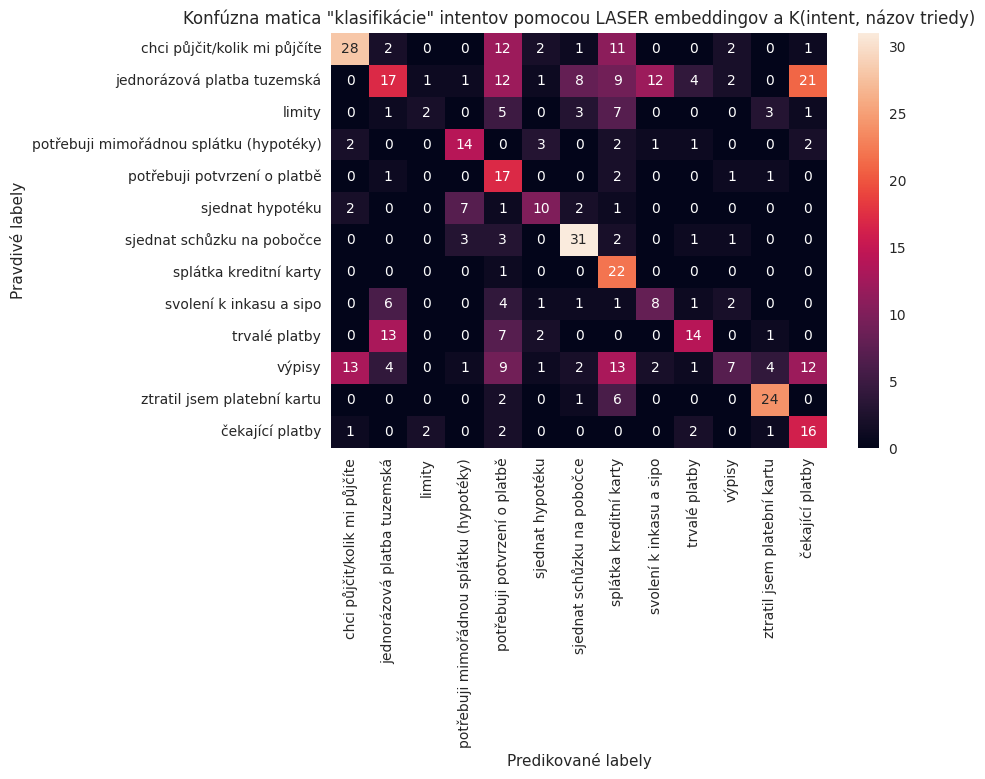

In [109]:
from sklearn.metrics import confusion_matrix

classes = df['kategorie'].unique()
class_embs_uniq = laser.embed_sentences(classes, lang='cs')
text_embs = laser.embed_sentences(df['text_cz'], lang='cs')

simil_int_classes = cosine_similarity(text_embs, class_embs_uniq)

y_pred = np.argmax(simil_int_classes, axis=1)
y_true = df['kategorie'].apply(classes.tolist().index).to_numpy()

t = confusion_matrix(y_true, y_pred, normalize=None)
t = np.round(t, 2)

plt.figure(dpi=100)
ax = sns.heatmap(t, annot=True, yticklabels=classes, xticklabels=classes)
ax.set(xlabel='Predikované labely',
       ylabel='Pravdivé labely',
       title='Konfúzna matica "klasifikácie" intentov pomocou FASTTEXT embeddingov a K(intent, názov triedy)')
# plt.title('Konfúzna matica "klasifikácie" intentov pomocou FASTTEXT embeddingov a K(intent, názov triedy)')
plt.show()

**táto konfúzna matica je veľmi náročná na interpretáciu, avšak je zjavné, že je nutné zrobustniť názvy tried**
### Pozorovanie

- vidíme konfúznu maticu, kde i-ty riadok a j-ty stĺpec indikuje počet vzoriek s pravdivým labelom v i-tej triede a predikoveným labelom v j-tej triede.
- triedy s krátkymi názvami (limity, půjčky, trvalé platby) nie sú predikované príliš často. 
  - zdá sa, že to může byť spôsobené krátkym názvom, ako bolo popísané vyššie.
- trieda "potřebuji potvrzení o platbě" je predikovaná často

### Záver 

- z konfúznej matice je vidno, že klasifikácia  len za pomoci sentence embeddingov a ich podobností je možná, ale nie príliš dobrá.
- očakávané vysoké čísla na diagonále tejto matice sa ukázali, ale nie je ich dostatočné množstvo.
- triedy "limity" a "výpisy", ktorých názov je, zdá sa, príliš krátky sú ťažko "predikovateľné".


In [1]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from nb_query_eval import Ensemble, QueryEvaluator, Tokenizer
from nb_query_eval.helpers import read_keyword_matrix

[nltk_data] Downloading package punkt to /home/sfabo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
t2b = pd.read_csv(os.getcwd() + '/data_text2bank/clean-pairs-enhanced-sort.csv')
labels = t2b['kategorie'].unique()

## Klasifikujme intenty len na základe kľúčových slov

Dáta nerozdeľujeme na trénovaciu a testovaciu množinu, keďže model je "predtrénovaný" expertne.

**Táto metóda bola použitá na zber celého datasetu text2bank**
- zber prebiehal pomocou webovej aplikácie, kde vybraní uživatelia zadávali intenty a tento "klasifikátor" ponúkal tri triedy s najvyššou hodnotou pravdepodobnosti
- uživateľ po vyhodnotení zvolil triedu, ktorú intentom myslel a ak sa tam nenachádzala, zvolil ju spomedzi všetkých tried z dropdown menu a/alebo pripísal poznámku k vyhodnoteniu a/alebo samotnému intentu

- použime naivného bayesa nad kľúčovými slovami (kľúčové slová sú v koreňových tvaroch, napr. slovo "půjčit" tu je v tvaroch "půjč", "půjči" - levenshtein zabezpečí ich podobnosť)
  - matica naivného bayesa má $k$ riadkov - kľúčových slov a $c$ stĺpcov - tried
  - na riadku $i$ je vektor, kde každá hodnota je bayesovským faktorom - výskyt daného kľúčového slova v danej triede
  - predikcia potom prebieha takto:
    - z intentu detekujeme len slová (bez stop slov)
    - pomocou levenshteinovej vzdialenosti nájdeme ku každému slovu v danom intente príslušné kľúčové slova (ich počet je parametrizovateľný)
    - pre dané slovo z intentu spočítame pravdepodobnosť príslušnosti k akejkoľvek triede
    - pre všetky slová z intentu tieto pravdepodobnosti príslušnosti spriemerujeme
    - na konci vypadne pravdepodobnosť príslušných tried daného intentu

Pozrime sa na výkonnosť tohoto expertného modelu na celom datasete text2bank

In [3]:
evaluators = [QueryEvaluator(keyword_matrix=read_keyword_matrix('nb_query_eval/resources/kw_matrix04.csv'), n_best_candidates=2, largest_mistake=1)]

with open('nb_query_eval/resources/stopwords.txt', 'r') as f:
    tokenizer = Tokenizer(f.readlines())

ens = Ensemble(action_names=labels, evaluators=evaluators, tokenizer=tokenizer, )

def batch_eval(text, ensamble):
    ensamble.fit(text)
    y_pred = ensamble.evaluate(sort_output=False)
    y_pred = [t[0] for t in y_pred]
    return y_pred

In [4]:
y_pred = t2b['text_cz'].apply(batch_eval, args=(ens,))

In [5]:
y_true = t2b['kategorie'].apply(lambda x: labels.tolist().index(x))

In [6]:
from sklearn.metrics import f1_score, top_k_accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def metrics_complex(logits, y_true, labels=list(range(90))):
    y_pred = logits
    # y_true_wgts = np.unique(y_true, return_counts=True)[1]
    # y_true_wgts = [y_true_wgts[y] for y in y_true]

    f1 = f1_score(y_true, np.argmax(y_pred, axis=1), labels=labels, average='weighted')

    acc_bal = balanced_accuracy_score(y_true, np.argmax(y_pred, axis=1))
    acc = top_k_accuracy_score(y_true, y_pred, k=1, labels=labels)
    acc_top3 = top_k_accuracy_score(y_true, y_pred, k=3, labels=labels)

    y_test_b = label_binarize(y=y_true, classes=np.array(labels))
    try:
        roc_auc = roc_auc_score(y_test_b, y_pred, multi_class='ovr')
    except:
        roc_auc = np.nan

    return {"f1": f1, "acc_bal": acc_bal, "acc": acc, "acc_top_3": acc_top3, "roc_auc": roc_auc}

In [7]:

y_pred = np.array([np.array(y) for y in y_pred])

In [8]:
metrics_complex(y_pred, y_true, labels=range(13))
# f1_score(y_true, np.argmax(y_pred, axis=1), labels=labels, average='weighted')

{'f1': 0.7936317969389797,
 'acc_bal': 0.7710110421025819,
 'acc': 0.7306122448979592,
 'acc_top_3': 0.8816326530612245,
 'roc_auc': 0.9626367808784753}

### Pozorovanie

- výpovedné hodnoty sú hlavne *balancovaná presnosť* a *top_3 presnosť* (accuracy)
- hodnoty sú pomerne vysoké aj pre tak jednoduchý model

### Zobrazme výsledky klasifikácie presnejšie

- pomocou konfúznej matice výsledkov a tzv. klasifikačného reportu
- konfúzna matica má na riadkoch pravdivé hodnoty a v stĺpcoch predikované
  - i-ty riadok je pravdivý label, j-ty stĺpec je predikovaný label

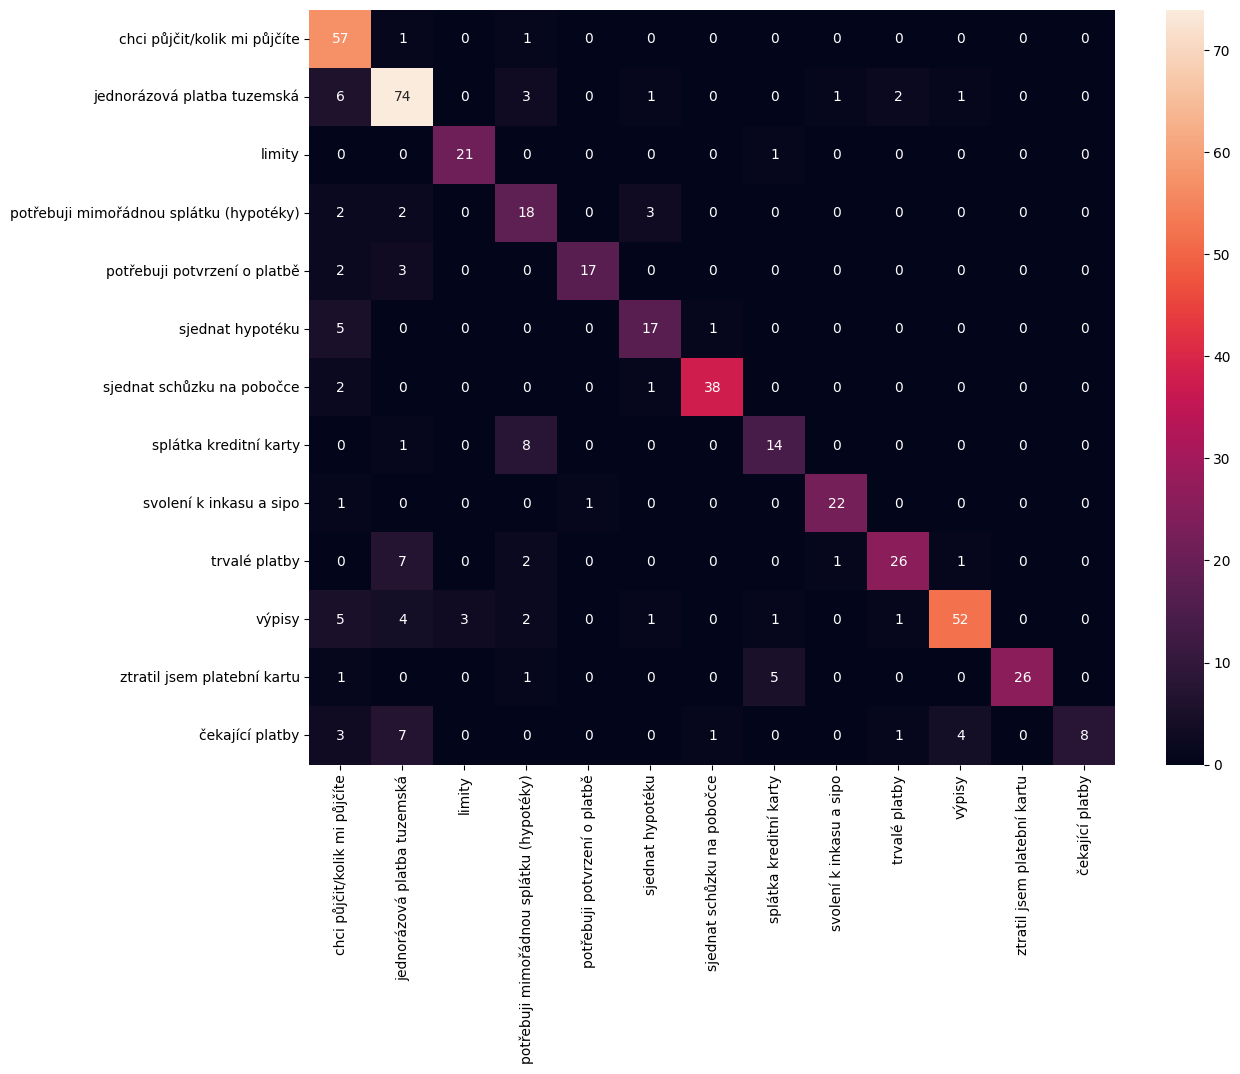

In [ ]:
from sklearn.metrics import confusion_matrix

c_mat = confusion_matrix(y_true.tolist(), np.argmax(y_pred, axis=1))
plt.figure(figsize=(13,10), dpi=100)
sns.heatmap(c_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=labels))
# labels

                                         precision    recall  f1-score   support

           chci půjčit/kolik mi půjčíte       0.68      0.97      0.80        59
            jednorázová platba tuzemská       0.75      0.84      0.79        88
                                 limity       0.88      0.95      0.91        22
potřebuji mimořádnou splátku (hypotéky)       0.51      0.72      0.60        25
           potřebuji potvrzení o platbě       0.94      0.77      0.85        22
                       sjednat hypotéku       0.74      0.74      0.74        23
             sjednat schůzku na pobočce       0.95      0.93      0.94        41
                 splátka kreditní karty       0.67      0.61      0.64        23
                svolení k inkasu a sipo       0.92      0.92      0.92        24
                          trvalé platby       0.87      0.70      0.78        37
                                 výpisy       0.90      0.75      0.82        69
            ztratil jsem pl

### Pozorovanie

- prekvapivo trieda "limity" má dosť vysoké f1 skóre, keďže každý intent z tejto triedy slovo "limit" v nejakej forme obsahuje.
  - za použitia kosínových podobností z predchádzajúcej analýzy táto trieda bola určená ako nie príliš rozumne skonštruovaná
  - to isté platí pre triedu "výpisy"

### Záver

Keďže dataset rozdelený na trénovaciu/testovaciu/validačnú množinu nebol, tieto čísla sú málo výpovedné a iba popisujú možný prístup klasifikácie intentov.

# Záver analýzy

- bola prevedená analýza podobností rôznych viet z datasetu text2bank (Profinit dáta)
- boli hlbšie preskúmané podobnosti vybraných viet z 2 tried
  - trieda limity má, zdá sa, príliš nízku sémantickú granularitu a bolo by vhodné ju vyradiť
    - vybrané vety z tejto triedy sa neukázali dostatočne podobné názvu triedy, ktorý je, zdá sa, príliš krátky a má široký význam
  - trieda "chci si půjčit" má, zdá sa, až na výnimky dostatočne vysokú sémantickú granularitu
    - avšak podobnosť intentov s názvom tejto triedy nie je príliš vysoká, odlíšenie od ostatných tried je podľa priemerných hodnôt kosínovej podobnosti nízke.
- Z klastrovacej analýzy intentov a jej vizualizácie pomocou UMAPu sa zdá, že nedokážeme pomocou LASERu strojovo rozdeľovať intenty do podtried (rozbíjať triedy na menšie a tým zvyšovať sémantickú granularitu). Potrebovali by sme dáta alebo predspracovať, alebo to urobiť manuálne.
- porovnali sme výkony rôznych embedérov v zmysle klasifikácie intentu do prislúchajúcej triedy len na základe kosínovej podobnosti
  - ukázalo sa, že je vhodné použiť dlhší, konkrétnejsí názov triedy a ako embedovaciu funkciu zvoliť FASTTEXT
  - avšak FASTTEXT v sebe uchováva viac informácií o vete, keďže embedovací priestor je väčší ako ostatné modely (FastText, FERNET)
- Klasifikovali sme celý dataset pomocou kľúčových slov, avšak výsledky tejto metódy berieme len ako prezentáciu toho, ako bol dataset vytvorený

- Analýza ukázala, že by bolo vhodné sémanticky upraviť dáta a názvy tried, ak by sme chceli klasifikovať intenty len na základe podobností s názvom príslišnej triedy
  - napr. trieda "limity" by mala alebo zaniknúť, alebo byť rozdelená do podtried (čo pri malom množstve vzorkov je nemysliteľné)

## Hypotézy na preverenie

- Ako by prebiehala klasifikácia len na základe kľúčových slov na nových dátach?
- Je nejak možné dáta pridať a upraviť tak, aby sme získali kvalitnejší a obšírnejší dataset - mohli trénovať komplexnejšie modely?

Je nutné zozbierať viac dát. 25-30 záznamov na triedu je jednoducho málo.